# NeRF: Neural Radiance Field

## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import nerf.infer
import nerf.train
import numpy as np
import torch
import torch.jit as jit

from ipynb.config import RenderConfig, TrainConfig
from ipynb.train import Trainer
from ipywidgets import widgets
from moviepy.editor import ImageSequenceClip
from nerf.data import BlenderDataset
from nerf.core import NeRF
from nerf.core import BoundedVolumeRaymarcher as BVR
from PIL import Image
from torch.cuda.amp import GradScaler
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm.auto import tqdm

torch.backends.cudnn.benchmark = True
%matplotlib inline

## Train

In [2]:
trainer = Trainer(TrainConfig())
trainer.display()

[BlenderDataset(hotdog, train)] Loading Data:   0%|          | 0/100 [00:00<?, ?it/s]

[BlenderDataset(hotdog, train)] Building Rays:   0%|          | 0/100 [00:00<?, ?it/s]

[Setup] Dataset Ready
[Setup] Model Ready
[Setup] Raymarcher Ready
[Setup] Optimsuite Ready
[Train] Fitting
[Train] Fitting Done


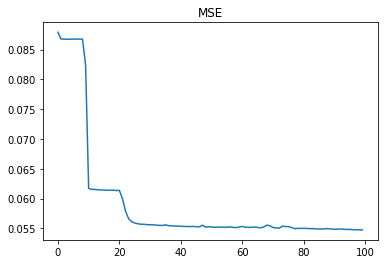

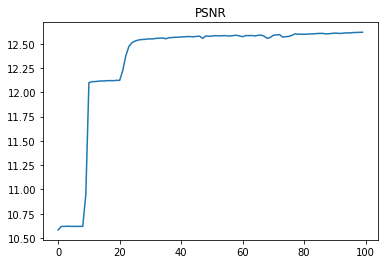

In [16]:
H = trainer.history

plt.figure()
plt.title("MSE")
plt.plot([mse for mse, _ in H.train], label="train")
plt.show()

plt.figure()
plt.title("PSNR")
plt.plot([psnr for _, psnr in H.train], label="train")
plt.show()

## Inference

### Setup

In [17]:
rcfg = RenderConfig()
rcfg.display()

### Data

In [19]:
val = BlenderDataset(rcfg.blender, rcfg.scene(), "val", step=rcfg.step(), scale=rcfg.scale())

[BlenderDataset(hotdog, val)] Loading Data:   0%|          | 0/5 [00:00<?, ?it/s]

[BlenderDataset(hotdog, val)] Building Rays:   0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
theta = -1 / 6 * np.pi, -1 / 6 * np.pi
phi = -np.pi, np.pi
radius = 4.

In [21]:
ros, rds = val.turnaround_data(theta=theta, phi=phi, radius=radius, samples=rcfg.frames())
W, H = val.W, val.H
S = W * H
n = len(ros)

[BlenderDataset(hotdog, val)] Building Rays:   0%|          | 0/120 [00:00<?, ?it/s]

### Model

In [22]:
nerf = jit.load(rcfg.model_ts).cuda()
raymarcher = BVR(*rcfg.t(), samples=rcfg.samples())

nerf.infer = lambda *args, **kwargs: NeRF.infer(nerf, *args, **kwargs)

### Inference

In [23]:
preds = np.zeros((rcfg.frames(), W, H, 3), dtype=np.uint8)
pbar = tqdm(range(0, n, S), desc="[NeRF] Frame")
for i, s in enumerate(pbar):
    ro, rd = ros[s:s + S], rds[s:s + S]
    pred = nerf.infer(raymarcher, ro, rd, W, H, batch_size=rcfg.batch_size(), verbose=False)
    preds[i] = pred.numpy().astype(np.uint8)

[NeRF] Frame:   0%|          | 0/120 [00:00<?, ?it/s]

In [24]:
clip = ImageSequenceClip(list(preds), durations=[1. / rcfg.fps()] * rcfg.frames())
clip.write_gif(rcfg.pred_gif, fps=rcfg.fps())

MoviePy - Building file ./res/NeRF_hotdog_pred.gif with imageio.


In [25]:
w_gif = widgets.Image(value=b"", format="gif", width=256, height=256)

with open(rcfg.pred_gif, "rb") as f:
    w_gif.value = f.read()
    
display(w_gif)

Image(value=b'GIF89a \x03 \x03\x87\x00\x00`N2VE-TC,RB+QA*P@)O?)N>)M>(M=\'L=(L<&K<\'K<&K;%J<\'J;&I;&I:%I9"H:&H9…